In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyro.infer import HMC, NUTS
from pyro.infer.mcmc import MCMC
import pdb
from src.models import HMC_vanilla


from tqdm import tqdm
%matplotlib inline

import sys
sys.path.insert(0, './src')

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
def set_seeds(rand_seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)
    torch.cuda.manual_seed_all(rand_seed)

In [147]:
torchType = torch.float32
class GMM():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-3., 0.], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.loc_2 = torch.tensor([3., 0.], dtype=torch.float32, device=device)
        self.covar_2 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        self.distr_2 = torch.distributions.MultivariateNormal(loc=self.loc_2, covariance_matrix=self.covar_2,)
        
        self.p = torch.tensor(0.5, dtype=torch.float32, device=device)
        self.bernoulli = torch.distributions.Bernoulli(probs=self.p)
        
    def log_prob(self, z, x=None):
        samples = z
        return torch.logsumexp(torch.cat([self.p.log() + self.distr_1.log_prob(samples)[None],
                                          (1. - self.p).log() + self.distr_2.log_prob(samples)[None]], dim=0), dim=0)
    
    def energy_function(self, init_params):
        z = init_params['points']
        return -self.log_prob(z)
    
    def sample(self, size):
        c = self.bernoulli.sample(size)[..., None]
        return c * self.distr_1.sample(size) + (1. - c) * self.distr_2.sample(size)
    
class Gaussian():
    def __init__(self, device):
        self.loc_1 = torch.tensor([-5., -2], dtype=torch.float32, device=device)
        self.covar_1 = torch.tensor([[1., 0.], [0., 1]], dtype=torch.float32, device=device)
        self.distr_1 = torch.distributions.MultivariateNormal(loc=self.loc_1, covariance_matrix=self.covar_1,)
        
    def log_prob(self, z, x=None):
        return self.distr_1.log_prob(z)
    
    def energy_function(self, init_params):
        return -self.distr_1.log_prob(z)
    
    def sample(self, size):
        return self.distr_1.sample(size)
    
    
class Banana():
    """
    Banana-shaped distribution
    """

    def __init__(self, device):
        self.d = 2
        self.device = device
        self.initial_gaussian = torch.distributions.MultivariateNormal(loc=torch.zeros(self.d, device=self.device),
                                                                       covariance_matrix=torch.tensor([[1., .9], [.9, 1.]], dtype=torchType, device=device) )
        self.a = torch.tensor(1.15, device=self.device, dtype=torchType)
        self.b = torch.tensor(-0.5, device=self.device, dtype=torchType)
        self.rho = torch.tensor([[1., .9], [.9, 1.]], dtype=torchType, device=device)[0, 1]


    def log_prob(self, z, x=None):
        x = z[:, 0]
        y = z[:, 1]
        log_density = -1. / (2 * (1. - self.rho ** 2)) * ((x / self.a) ** 2
                                                          + self.a ** 2 * (
                                                                  y - self.b * x ** 2 / self.a ** 2 - self.b * self.a ** 2) ** 2
                                                          - 2 * self.rho * (
                                                                  y - self.b * x ** 2 / self.a ** 2 - self.b * self.a ** 2))
        return log_density

    def energy_function(self, init_params):
        z = init_params['points']
        return -self.log_prob(z)
    
    def sample(self, n):
        # sample from true target
        gaussian_samples = self.initial_gaussian.sample(n)
        x = self.a * gaussian_samples[:, 0]
        y = gaussian_samples[:, 1] / self.a + self.b * (gaussian_samples[:, 0] ** 2 + self.a ** 2)
        samples = torch.cat([x[:, None], y[:, None]], dim=-1)
        return samples

    
class Banana_mixture():
    """
    Banana-shaped distribution mixture
    """

    def __init__(self, device):
        self.d = 2
        self.num = 2
        self.device=device
        self.locs = torch.tensor([[7, 0.], [-7, 0.]], dtype=torchType, device=device) ###For now use 0 on y axis !! 
        self.cov = torch.tensor([[1., .9], [.9, 1.]], dtype=torchType, device=device) 
        self.a = torch.tensor([1.15,1.15], device=self.device, dtype=torchType)
        self.b = torch.tensor([-0.5,0.5], device=self.device, dtype=torchType)
        self.rho =torch.tensor([[1., .9], [.9, 1.]], dtype=torchType, device=device)[0, 1]
        self.initial_gaussian = torch.distributions.MultivariateNormal(loc=torch.zeros(self.d, device=self.device),
                                                                       covariance_matrix=torch.tensor([[1., .9], [.9, 1.]], dtype=torchType, device=device) )
        
    def log_prob(self, z, x=None):
        x = z[:, 0]
        y = z[:, 1]
        log_density = torch.tensor([])
        for i in range(self.num):
            log_paux = -1. / (2 * (1. - self.rho ** 2)) * ((x / self.a[i] - self.locs[i][0]) ** 2
                                                           + self.a[i] ** 2 * (
                                                                   y - self.b[i] * x ** 2 / self.a[i] ** 2 - self.b[
                                                               i] * self.a[i] ** 2 - self.locs[i][1]) ** 2
                                                           - 2 * self.rho * (
                                                                   y - self.b[i] * x ** 2 / self.a[i] ** 2 - self.b[i] * self.a[i] ** 2 - self.locs[i][1]))
            p#db.set_trace()

            log_density = torch.cat([log_density, log_paux[None,:]], dim=0)

        log_density = torch.logsumexp(log_density, dim=0)
        return log_density
    
    def energy_function(self, init_params):
        z = init_params['points']
        return -self.log_prob(z)
    
    def sample(self, n):
        # sample from true target
        gaussian_samples = self.initial_gaussian.sample(n)
        p = np.random.choice(a=self.num, size=n)
        x = self.a[p] * (gaussian_samples[:, 0] + self.locs[p, 0])
        y = gaussian_samples[:, 1] / self.a[p] + self.b[p] * (gaussian_samples[:, 0] ** 2 + self.a[p] ** 2) ##Only valid for mu_y = 0 !!
        samples = torch.cat([x[:, None], y[:, None]], dim=-1)
        return samples


In [148]:
target = Banana_mixture(device=device)
target2 = GMM(device=device)

In [ ]:
samples.shape
samples2 = target.sample((5000,))
a = samples2[:,0]
b = samples2[:,1]
torch.cat([a,b], dim=-1)

<ipython-input-149-49476e1d68a2>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(xx, yy, p, norm=mcolors.PowerNorm(0.5))


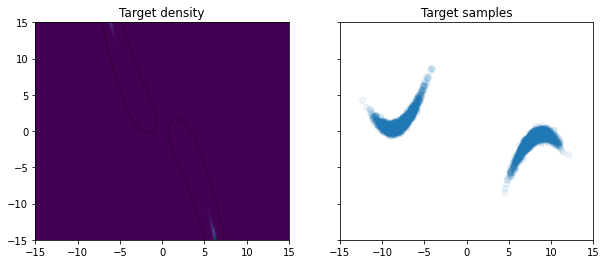

In [149]:
x_lim = 15


y_lim = 15
npts = 500

xside = np.linspace(-x_lim - 1, x_lim + 1, npts)
yside = np.linspace(-y_lim - 1, y_lim + 1, npts)
xx, yy = np.meshgrid(xside, yside)
z = torch.tensor(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]), device=device, dtype=torch.float32)
logdens = target.log_prob(z)
p = np.exp(logdens.cpu().detach().numpy().reshape(npts, npts))

fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].set_title('Target density')
ax[0].pcolormesh(xx, yy, p, norm=mcolors.PowerNorm(0.5))
ax[0].contour(xx, yy, p, 15, colors='black', alpha=0.2);
ax[0].set_xlim(-x_lim, x_lim)
ax[0].set_ylim(0, y_lim)
ax[0].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[0].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

ax[1].set_title('Target samples')
samples = target.sample((5000, )).cpu().detach().numpy()
ax[1].scatter(samples[:, 0], samples[:, 1], alpha=0.075)
ax[1].set_xticks(np.arange(-x_lim, x_lim + 1, 5))
ax[1].set_yticks(np.arange(-y_lim, y_lim + 1, 5));

In [143]:
logdens

tensor([-23852.2090, -23412.8789, -22979.4414,  ..., -23736.4121,
        -24177.1523, -24623.8164])

In [150]:
args = dotdict({})

args['device'] = device
args['torchType'] = torch.float32
args['N'] = 5
args['alpha'] = 0.5
args['gamma'] = 1.
args['use_partialref'] = False
args['use_barker'] = False

In [145]:
def q_0(mu, std, z):
    return torch.distributions.Normal(loc=mu, scale=std).log_prob(z)

def instantaneous_ELBO(z, mu, std, target):
    KL = -q_0(mu, std, z).mean() + target.log_prob(z).mean()
    return KL



def VCD(z, mu, std, target, control_variate):
    first_term = -instantaneous_ELBO(z, mu, std, target)
    z_mcmc = run_mcmc(z.detach())
    
    second_aux = instantaneous_ELBO(z_mcmc, mu, std, target).detach()
    second_term = -q_0(mu, std, z_mcmc).mean() + (second_aux - control_variate) * q_0(mu, std, z).mean()
    control_variate = gamma_ma * control_variate + (1. - gamma_ma) * second_aux
    vcd = first_term + second_term
    
    return vcd, control_variate, z_mcmc

def run_mcmc_pyro(z):
    z_mcmc = torch.tensor([], device=device, dtype=torch.float32)
    for i in range(z.shape[0]):
        init_samples = z[i]
        init_params = {'points': init_samples}
        mcmc = MCMC(kernel=kernel, num_samples=1, warmup_steps=5, initial_params=init_params, disable_progbar=True)
        mcmc.run()
        z_mcmc = torch.cat([z_mcmc, mcmc._samples['points'].squeeze()[None]], dim=0)
    return z_mcmc

def run_mcmc(z):
    z_mcmc = z
    gamma = args.gamma
    for i in range(L):
        z_mcmc, _, _ = transition.make_transition(z_mcmc, None, target)
    return z_mcmc

In [151]:
batch_size = 100
n_batches = 2001
lr = 0.01

control_variate = 0.
gamma_ma = 0.9  # moving average

kernel = HMC(potential_fn=target.energy_function, num_steps=5,)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., dtype=torch.float32, device=device),
                                       scale=torch.tensor(1., dtype=torch.float32, device=device))

## Forward KL

In [152]:
set_seeds(111)

In [153]:
mu = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
logvar = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
params = [mu, logvar]
optimizer = torch.optim.RMSprop(params=params, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

  0%|          | 0/2001 [00:00<?, ?it/s]

kl is 110.08300018310547
mu is [0.1 0.1]
logvar is [ 0.09999999 -0.1       ]


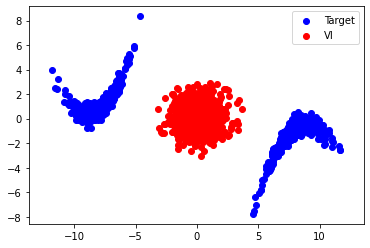

  3%|▎         | 68/2001 [00:00<03:53,  8.27it/s]

kl is 70.45340728759766
mu is [ 2.3174064 -1.4991838]
logvar is [-1.0004654 -1.4318261]


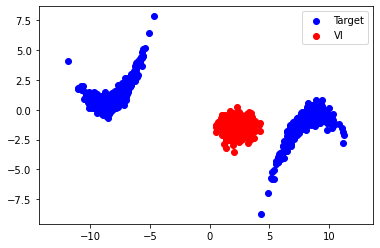

  9%|▉         | 177/2001 [00:00<01:50, 16.49it/s]

kl is 52.88444519042969
mu is [ 3.0883214 -2.8462038]
logvar is [-1.9159747 -1.9444026]


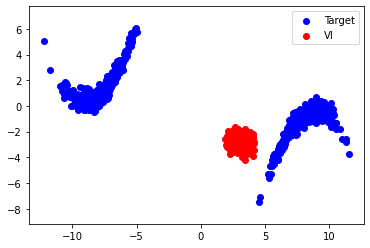

 14%|█▍        | 290/2001 [00:00<00:53, 32.26it/s]

kl is 43.387821197509766
mu is [ 3.5475636 -3.951686 ]
logvar is [-2.5804734 -2.308915 ]


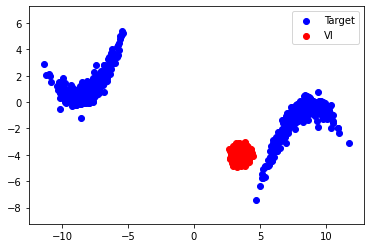

 17%|█▋        | 336/2001 [00:00<00:37, 43.84it/s]

kl is 37.28096008300781
mu is [ 3.86993   -4.9467125]
logvar is [-3.1269355 -2.4600716]


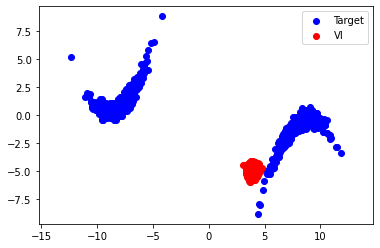

 24%|██▎       | 471/2001 [00:01<00:18, 81.10it/s]

kl is 31.41212272644043
mu is [ 4.1569824 -5.8784842]
logvar is [-3.636732  -2.5623088]


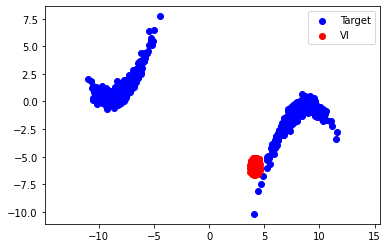

 30%|██▉       | 593/2001 [00:01<00:10, 137.77it/s]

kl is 26.771093368530273
mu is [ 4.424499 -6.784252]
logvar is [-4.0971146 -2.6241927]


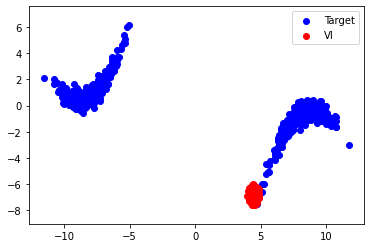

 32%|███▏      | 644/2001 [00:01<00:08, 163.65it/s]

kl is 23.310436248779297
mu is [ 4.6720586 -7.675577 ]
logvar is [-4.5080643 -2.6556933]


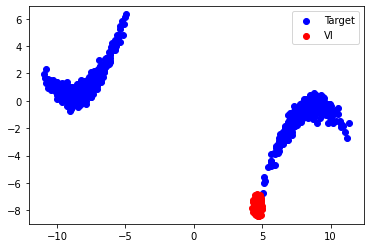

 38%|███▊      | 767/2001 [00:02<00:05, 238.03it/s]

kl is 20.16511344909668
mu is [ 4.879355 -8.562314]
logvar is [-4.8450465 -2.631356 ]


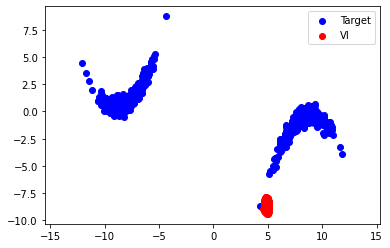

 44%|████▍     | 890/2001 [00:02<00:03, 304.36it/s]

kl is 17.425931930541992
mu is [ 5.100889 -9.44151 ]
logvar is [-5.14095   -2.6617944]


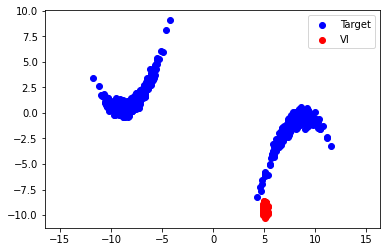

 47%|████▋     | 941/2001 [00:02<00:03, 294.61it/s]

kl is 14.710259437561035
mu is [  5.323964  -10.3158455]
logvar is [-5.3610716 -2.6034381]


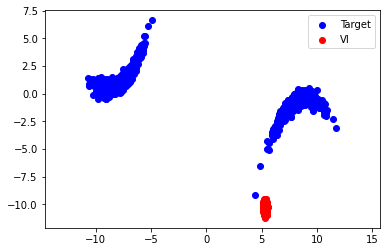

 53%|█████▎    | 1069/2001 [00:02<00:02, 352.25it/s]

kl is 12.646849632263184
mu is [  5.513601  -11.1911955]
logvar is [-5.504571  -2.6735983]


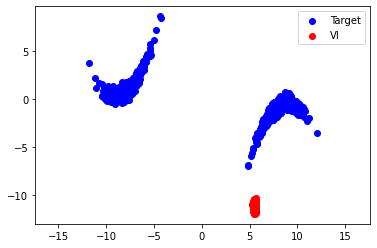

 60%|█████▉    | 1193/2001 [00:03<00:02, 350.34it/s]

kl is 10.674834251403809
mu is [  5.71299  -12.061039]
logvar is [-5.5569005 -2.593831 ]


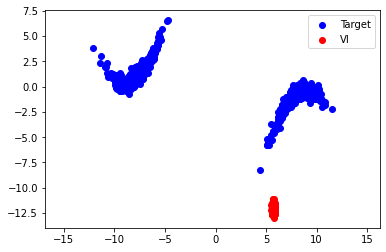

 62%|██████▏   | 1244/2001 [00:03<00:02, 300.12it/s]

kl is 8.836979866027832
mu is [  5.919998 -12.926639]
logvar is [-5.6491804 -2.6340625]


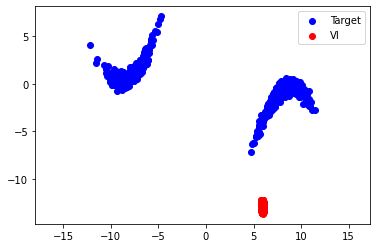

 69%|██████▊   | 1372/2001 [00:03<00:01, 357.20it/s]

kl is 7.355372428894043
mu is [  6.0831485 -13.789674 ]
logvar is [-5.676308  -2.6694832]


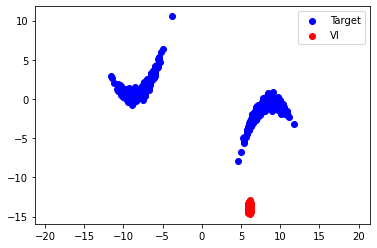

 75%|███████▍  | 1492/2001 [00:03<00:01, 387.41it/s]

kl is 5.979421138763428
mu is [  6.277583 -14.63417 ]
logvar is [-5.7391863 -2.6078584]


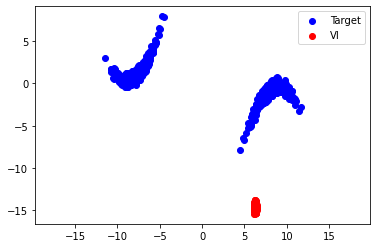

 77%|███████▋  | 1543/2001 [00:04<00:01, 325.55it/s]

kl is 4.833130359649658
mu is [  6.452183 -15.473192]
logvar is [-5.788159  -2.6485956]


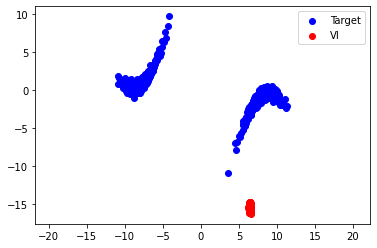

 84%|████████▍ | 1678/2001 [00:04<00:00, 376.08it/s]

kl is 3.673938512802124
mu is [  6.6011133 -16.300505 ]
logvar is [-5.8185325 -2.6353781]


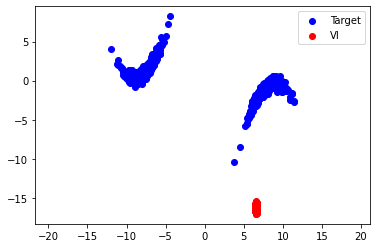

 90%|████████▉ | 1792/2001 [00:04<00:00, 384.87it/s]

kl is 3.1016056537628174
mu is [  6.7561483 -17.116276 ]
logvar is [-5.9415703 -2.643077 ]


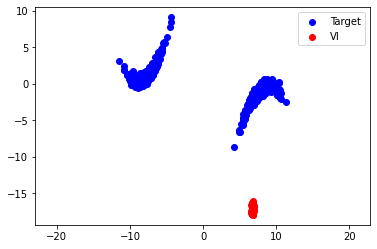

 92%|█████████▏| 1841/2001 [00:04<00:00, 339.79it/s]

kl is 2.296083688735962
mu is [  6.9133945 -17.90832  ]
logvar is [-5.935447  -2.6223576]


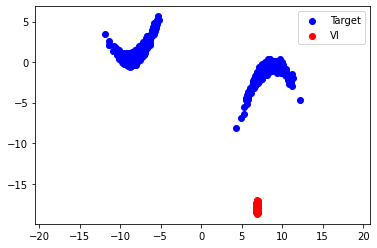

 99%|█████████▊| 1975/2001 [00:05<00:00, 395.53it/s]

kl is 1.710068941116333
mu is [  7.051224 -18.675089]
logvar is [-5.982232  -2.5993898]


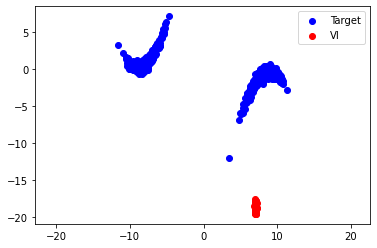

100%|██████████| 2001/2001 [00:05<00:00, 366.13it/s]


In [154]:
for b_num in tqdm(range(n_batches)):
    plt.close()
    eps = std_normal.sample((batch_size, 2))
    std = torch.exp(logvar * 0.5)
    z = mu + eps * std
    kl = compute_KL(z, mu, std, target)
    kl.backward()
    optimizer.step()
    optimizer.zero_grad()
#     scheduler.step()
    with torch.no_grad():
        if b_num % 100 == 0:
            print(f'kl is {kl.cpu().detach().item()}')
            print(f'mu is {mu.cpu().detach().numpy()}')
            print(f'logvar is {logvar.cpu().detach().numpy()}')
            std = torch.exp(0.5 * logvar)
            samples_target = target.sample((1000, )).cpu().detach().numpy()
            samples_vi = (mu + std_normal.sample((1000, 2)) * std).cpu().detach().numpy()
            plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
            plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VI', c='r')
            plt.legend()
            plt.axis('equal')
            plt.show()

## VCD

In [22]:
set_seeds(111)

In [23]:
L = 20
transition = HMC_vanilla(args)

#### MCMC validation

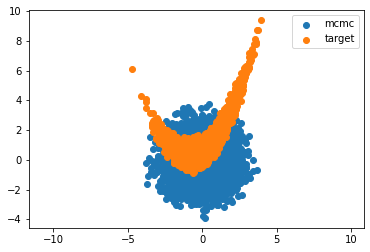

In [73]:
samples_mcmc = run_mcmc(torch.randn(10000, 2).to(torch.device(device))).cpu().numpy()
samples_target = target.sample((samples.shape[0], )).cpu().numpy()
plt.scatter(samples_mcmc[:, 0], samples_mcmc[:, 1], label='mcmc')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='target')
plt.axis('equal')
plt.legend();

In [74]:
control_variate = 0.

mu = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
logvar = nn.Parameter(torch.tensor([0., 0.], dtype=torch.float32, device=device))
params = [mu, logvar]
optimizer = torch.optim.RMSprop(params=params, lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

  0%|          | 0/2001 [00:00<?, ?it/s]

mu is [-0.09999999  0.09999999]
logvar is [-0.1        -0.09999999]
control_variate is -1.4592618942260742


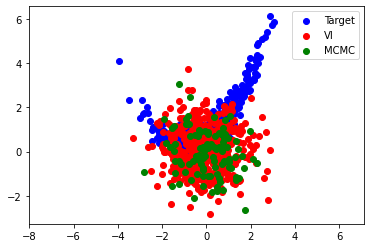

  5%|▍         | 99/2001 [00:06<01:57, 16.22it/s]

mu is [0.00575985 1.3263571 ]
logvar is [-1.0601659 -1.18479  ]
control_variate is 0.34469741582870483


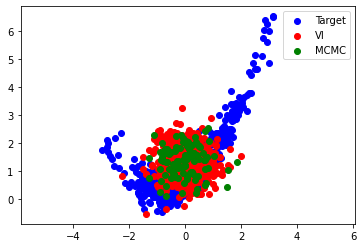

 10%|▉         | 199/2001 [00:12<01:49, 16.47it/s]

mu is [0.0222869 1.4389293]
logvar is [-1.3945438 -1.7072403]
control_variate is 1.038014531135559


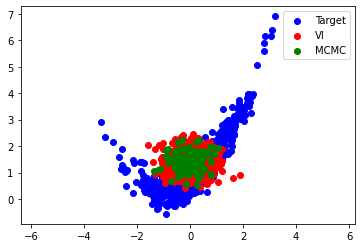

 15%|█▍        | 299/2001 [00:18<01:41, 16.70it/s]

mu is [-0.00612035  1.4172866 ]
logvar is [-1.6705676 -2.0908957]
control_variate is 1.2218810319900513


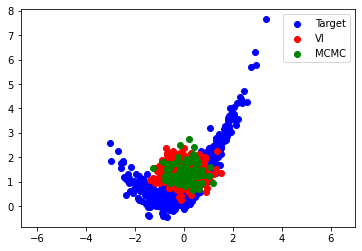

 20%|█▉        | 399/2001 [00:24<01:38, 16.30it/s]

mu is [0.00625694 1.3989683 ]
logvar is [-1.8852055 -2.3639028]
control_variate is 1.3094745874404907


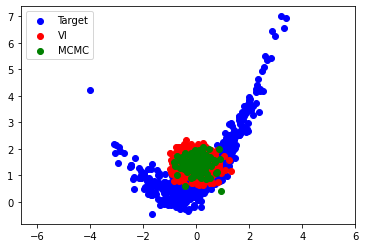

 25%|██▍       | 499/2001 [00:30<01:27, 17.08it/s]

mu is [-0.00369699  1.3898667 ]
logvar is [-2.0484102 -2.5343285]
control_variate is 1.333909511566162


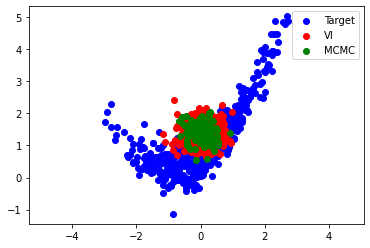

 30%|██▉       | 599/2001 [00:37<01:32, 15.08it/s]

mu is [0.00189583 1.3876595 ]
logvar is [-2.1369483 -2.6045365]
control_variate is 1.3372305631637573


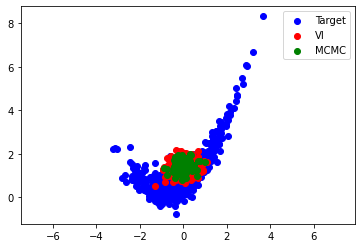

 35%|███▍      | 699/2001 [00:43<01:28, 14.73it/s]

mu is [0.00278927 1.3820586 ]
logvar is [-2.1436176 -2.6183698]
control_variate is 1.3454707860946655


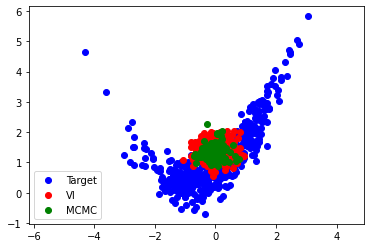

 40%|███▉      | 799/2001 [00:51<01:21, 14.67it/s]

mu is [0.00497251 1.3876549 ]
logvar is [-2.176658  -2.6246135]
control_variate is 1.340990424156189


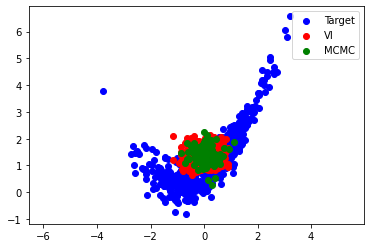

 45%|████▍     | 899/2001 [00:58<01:13, 14.96it/s]

mu is [0.00418465 1.3994747 ]
logvar is [-2.149969  -2.6201282]
control_variate is 1.345345139503479


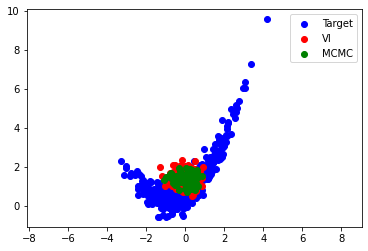

 50%|████▉     | 999/2001 [01:05<01:08, 14.64it/s]

mu is [-0.00947564  1.3818686 ]
logvar is [-2.1672733 -2.6255355]
control_variate is 1.3404922485351562


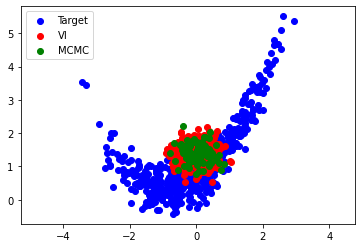

 55%|█████▍    | 1099/2001 [01:12<01:00, 14.92it/s]

mu is [0.01322803 1.3869538 ]
logvar is [-2.1773493 -2.6189241]
control_variate is 1.3404890298843384


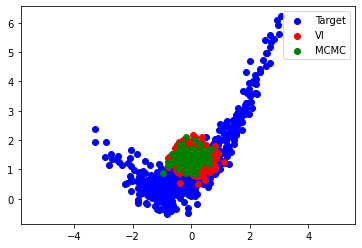

 60%|█████▉    | 1199/2001 [01:19<00:56, 14.29it/s]

mu is [0.01576543 1.3855149 ]
logvar is [-2.1440086 -2.6150105]
control_variate is 1.3460618257522583


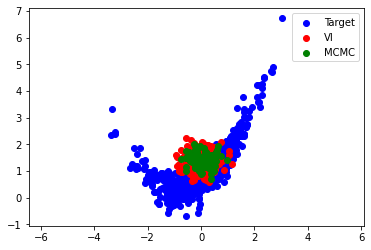

 65%|██████▍   | 1299/2001 [01:26<00:48, 14.52it/s]

mu is [-0.00241815  1.3899777 ]
logvar is [-2.1311374 -2.6324499]
control_variate is 1.3422080278396606


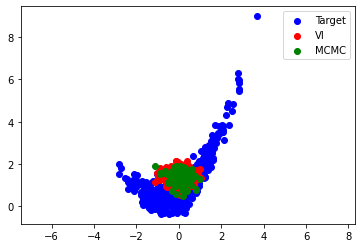

 70%|██████▉   | 1399/2001 [01:33<00:40, 14.80it/s]

mu is [0.00452069 1.3912603 ]
logvar is [-2.1667202 -2.6149983]
control_variate is 1.3418172597885132


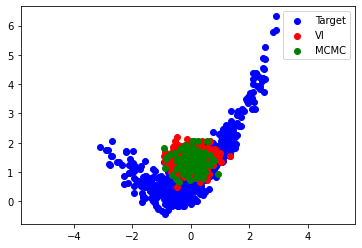

 75%|███████▍  | 1499/2001 [01:40<00:33, 15.07it/s]

mu is [0.0125154 1.3848937]
logvar is [-2.109049  -2.6129835]
control_variate is 1.344794511795044


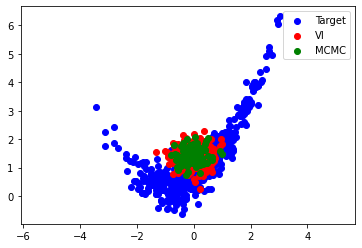

 80%|███████▉  | 1599/2001 [01:47<00:26, 15.01it/s]

mu is [0.01138445 1.3914199 ]
logvar is [-2.1441119 -2.6108298]
control_variate is 1.3463115692138672


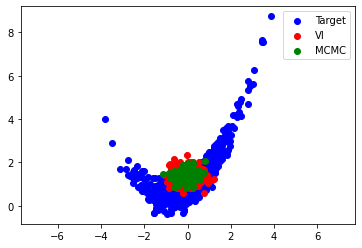

 85%|████████▍ | 1699/2001 [01:54<00:20, 15.06it/s]

mu is [-0.01132957  1.3791811 ]
logvar is [-2.1558917 -2.632782 ]
control_variate is 1.3404582738876343


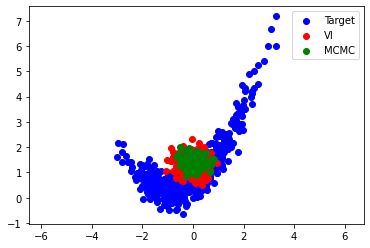

 90%|████████▉ | 1799/2001 [02:00<00:14, 14.38it/s]

mu is [0.00860274 1.3953453 ]
logvar is [-2.1463454 -2.6282997]
control_variate is 1.343977689743042


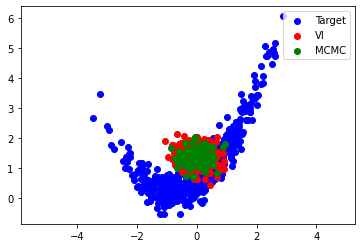

 95%|█████████▍| 1899/2001 [02:07<00:06, 14.69it/s]

mu is [-0.00355051  1.385299  ]
logvar is [-2.1617918 -2.6312814]
control_variate is 1.3419185876846313


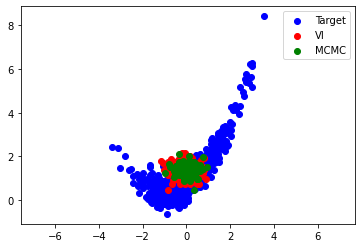

100%|█████████▉| 1999/2001 [02:14<00:00, 14.80it/s]

mu is [-0.00139151  1.3736846 ]
logvar is [-2.132867  -2.5883243]
control_variate is 1.3448994159698486


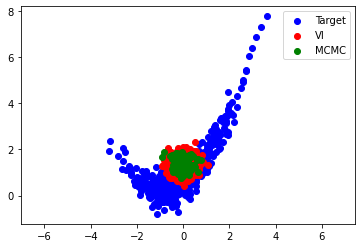

100%|██████████| 2001/2001 [02:15<00:00, 14.82it/s]


In [75]:
for b_num in tqdm(range(n_batches)):
    plt.close()
    batch = target.sample((batch_size, ))
    eps = std_normal.sample(batch.shape)
    std = torch.exp(logvar * 0.5)
    z = mu + eps * std
    vcd, control_variate, z_mcmc = VCD(z, mu, std, target, control_variate)
    vcd.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        if b_num % 100 == 0:
            print(f'mu is {mu.cpu().detach().numpy()}')
            print(f'logvar is {logvar.cpu().detach().numpy()}')
            print(f'control_variate is {control_variate}')
            samples_target = target.sample((z_mcmc.shape[0] * 5, )).cpu().detach().numpy()
            z_mcmc = z_mcmc.cpu().numpy()
            samples_vi = (mu + std_normal.sample((z_mcmc.shape[0] * 5, 2)) * torch.exp(0.5 * logvar)).cpu().detach().numpy()
            plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
            plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='VI', c='r')
            plt.scatter(z_mcmc[:, 0], z_mcmc[:, 1], label='MCMC', c='g')
            plt.legend()
            plt.axis('equal')
            plt.show()

## Visualisation of final samples

In [21]:
n_samples = 1000

In [22]:
mu_vcd = mu.detach()
logvar_vcd = logvar.detach()

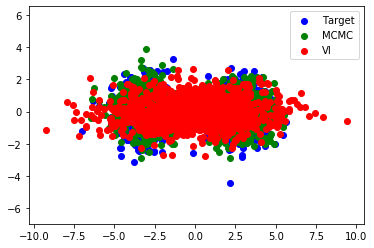

In [25]:
batch = target.sample((n_samples, ))
eps = std_normal.sample(batch.shape)
z = mu_vcd + eps * torch.exp(logvar_vcd * 0.5)
mcmc = run_mcmc(z.detach())
samples_target = batch.cpu().detach().numpy()
samples_vi = z_vcd.cpu().detach().numpy()
z = z.cpu().detach().numpy()
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target', c='b')
plt.scatter(samples_vi[:, 0], samples_vi[:, 1], label='MCMC', c='g')
plt.scatter(z[:, 0], z[:, 1], label='VI', c='r')
plt.legend()
plt.axis('equal')
plt.show()